# Imports

In [1]:
import pandas as pd
import pickle
    
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import *
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import set_config
import numpy as np
from numpy.random import randint
from datetime import datetime
import matplotlib.pyplot as plt

# Helpers

## These might need to go in a separate file and then import them

In [2]:
class CalculateCustomerAge(BaseEstimator, TransformerMixin):
    """
    A class to calculate the age of a customer that can be used in an sklearn pipeline.

    ...

    Methods
    -------
    transform(X):
        Takes the input dataframe X and calculates the age of the customer.
    """
    def __init__(self):
        None
    # Trivial method to be compatible with Sklearn pipeline
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        """
        Calculates the age of a customer.


        Parameters
        ----------
        X : pd.DataFrame

        Returns
        -------
        df (pd.DataFrame): Pandas data frame with customer age appended.
        """
        
        df = X.copy()
        
        today = datetime.today().strftime('%Y-%m-%d')
        today = pd.to_datetime(today, format = '%Y-%m-%d')
        
        df['CUSTOMER_AGE'] = ((today - pd.to_datetime(df['DATE_OF_BIRTH'], format = '%d-%m-%Y'))).astype('<m8[Y]')
        
        df = df.drop(columns = 'DATE_OF_BIRTH')
        

        return df

In [3]:
class CalculateCreditHistoryLength(BaseEstimator, TransformerMixin):
    """
    A class to calculate a customer's credit history length that can be used in an sklearn pipeline.

    ...

    Methods
    -------
    transform(X):
        Takes the input dataframe X and calculates the credit history length of the customer.
    """
    def __init__(self):
        None
    # Trivial method to be compatible with Sklearn pipeline
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        """
        Calculates the credit history length of a customer.


        Parameters
        ----------
        X : pd.DataFrame

        Returns
        -------
        df (pd.DataFrame): Pandas data frame with customer credit history length appended.
        """
        
        df = X.copy()
        
        credit_history_length = df['CREDIT_HISTORY_LENGTH'].str.split(' ', expand = True)
        
        months_credit_history_length = pd.Series(credit_history_length[1].str.extract('(\d+)')[0]).astype(int)
        years_credit_history_length = pd.Series(credit_history_length[0].str.extract('(\d+)')[0]).astype(int) * 12
        
        df['CREDIT_HISTORY_LENGTH'] = months_credit_history_length + years_credit_history_length
        

        return df

In [4]:
class CalculateAverageAccountLength(BaseEstimator, TransformerMixin):
    """
    A class to calculate a customer's average account age that can be used in an sklearn pipeline.

    ...

    Methods
    -------
    transform(X):
        Takes the input dataframe X and calculates the average account age of a customer.
    """
    def __init__(self):
        None
    # Trivial method to be compatible with Sklearn pipeline
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        """
        Calculates the average account age of a customer.


        Parameters
        ----------
        X : pd.DataFrame

        Returns
        -------
        df (pd.DataFrame): Pandas data frame with customer's average account age appended.
        """
        
        df = X.copy()
        
        average_acct_length = df['AVERAGE_ACCT_AGE'].str.split(' ', expand = True)

        
        months_average_acct_length = pd.Series(average_acct_length[1].str.extract('(\d+)')[0]).astype(int)
        years_average_acct_length = pd.Series(average_acct_length[0].str.extract('(\d+)')[0]).astype(int) * 12
        
        
        df['AVERAGE_ACCT_AGE'] = months_average_acct_length + years_average_acct_length

        return df

In [5]:
def create_xgb_classifier_pipeline(categorical_features, numeric_features, all_cols, seed=42):
    """
    Creates an sklearn pipeline composed of feature engineering and xgboost classifier components.
    Pipeline objects are easier to manage when deploying


    Parameters
    ----------
    categorical_features : list
        A python list containing the categorical feature names
        
    numeric_features : list
        A python list containing the numeric feature names
        
    all_cols : list
        A python list containing all of the column names
    
        
        

    Returns
    -------
    pipe_xgb (sklearn.Pipeline): Sklearn Pipeline with two steps. The feature engineering / preprocessing and XGBoost classifier
    """
  

    # Create the categorical imputer and ordinal encoder objects
    preprocessing = [('categorical_imputer', SimpleImputer(strategy = 'constant', fill_value = 'unknown')),
                ('ordinal_encoder', OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = -1))]


    categorical_transformer = Pipeline(steps = preprocessing)

    
    # Perform feature engineering
    feature_engineering = [('customer_age_calc', CalculateCustomerAge()),
                           ('credit_history_length_calc', CalculateCreditHistoryLength()),
                          ('average_account_length_calc', CalculateAverageAccountLength())]






    feature_engineering_transformer = Pipeline(steps = feature_engineering)
    
    
    # Select which features belong to which transformer
    preprocessor = ColumnTransformer(
    transformers=[
        ('categorical_transformers', categorical_transformer, categorical_features),
        ('feature_engineering', feature_engineering_transformer, numeric_features),
    ])

    
    pipe_preprocessor = Pipeline(steps = [('preprocessor', preprocessor)])
    
    # create pipeline that does the preprocessing and then creates XGBoost classifier model
    pipe_xgb = Pipeline(steps = [('preprocessor_pipe', pipe_preprocessor),('clf',  XGBClassifier(random_state = seed))])
    

  
    return pipe_xgb

In [15]:
def train_xgb_model(seed=42):
    """
    Reads in the data, does the train / test split, downsamples the majority class, then trains and saves
        the XGBoost classifier model with performance metrics.


    Parameters
    ----------
    None
    
        
        

    Returns
    -------
    None
    """
    
    
    
    
    
    

    # read data
    data_path = 'C:/Users/H244746/Desktop/Deployment Exercise/archive_original/train.csv'
    data = pd.read_csv(data_path)

    
    # assign target
    y = data['LOAN_DEFAULT']
    X = data.drop(columns = ['UNIQUEID', 'LOAN_DEFAULT'])
    

    # select input for model
    X = X[['PERFORM_CNS_SCORE','NO_OF_INQUIRIES','PRI_OVERDUE_ACCTS','STATE_ID','LTV','EMPLOYMENT_TYPE',
           'VOTERID_FLAG','DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS','PRI_SANCTIONED_AMOUNT','MANUFACTURER_ID',
           'DATE_OF_BIRTH', 'CREDIT_HISTORY_LENGTH', 'AVERAGE_ACCT_AGE']]
    

    # train test split
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = .2, random_state = seed)

    
    # downsample the majority class
    n_minority = (y_train == 1).sum()
    y_train_down = y_train[y_train == 0].sample(n_minority, replace=False, random_state = seed)
    X_train_down = X_train.loc[y_train_down.index,:]

    minority_index = y_train[y_train == 1].index.to_list()
    minority_index = minority_index + y_train_down.index.to_list()


    X_train = X_train.loc[minority_index,:]
    y_train = y_train.loc[minority_index]
    
    
    print(y_train.value_counts())
    
    
    # TODO need to go back and make this less hack
    # Get numeric feature names
    numeric_features = X_train.select_dtypes('number').columns.to_list()
    numeric_features.append('DATE_OF_BIRTH')
    numeric_features.append('CREDIT_HISTORY_LENGTH')
    numeric_features.append('AVERAGE_ACCT_AGE')
    print(len(numeric_features))


    # Get categorical feature names
    categorical_features = X_train.select_dtypes('object').columns.to_list()
    categorical_features.remove('DATE_OF_BIRTH')
    categorical_features.remove('CREDIT_HISTORY_LENGTH')
    categorical_features.remove('AVERAGE_ACCT_AGE')
    print(len(categorical_features))
    
    
    # incase we want to return data frame with column names
    all_cols = categorical_features + numeric_features + ['CUSTOMER_AGE']
    all_cols.remove('DATE_OF_BIRTH')



    # Create pipeline
    pipe = create_xgb_classifier_pipeline(categorical_features = categorical_features, numeric_features = numeric_features, all_cols = all_cols, seed = seed)


    # Fit pipeline
    pipe.fit(X_train, y_train)


    # Make predictions on test set and generate confusion matrix
    y_preds = pipe.predict(X_test)
    cm = ConfusionMatrixDisplay.from_predictions(y_true=y_test, y_pred=y_preds)


    # Accuracy of model
    train_accuracy = accuracy_score(y_train, pipe.predict(X_train))
    test_accuracy = accuracy_score(y_test, y_preds)
    
    train_recall = recall_score(y_train, pipe.predict(X_train))
    test_recall = recall_score(y_test, y_preds)

    # Save metrics to dictionary
    performance_metrics = {'train_accuracy':train_accuracy, 'test_accuracy':test_accuracy, 'train_recall':train_recall, 'test_recall':test_recall}
    print(performance_metrics)
    

    # Pickle model performance
    performance_path = 'C:\\Users\\H244746\\Desktop\\Deployment Exercise\\performance_metrics\\loan_default_classifier_performance_test.sav'
    with open(performance_path, 'wb') as handle:
        pickle.dump(performance_metrics, handle)


    
    
    # Pickle pipeline
    pipeline_path = 'C:\\Users\\H244746\\Desktop\\Deployment Exercise\\models\\loan_default_pipeline_classifier_test.sav'
    with open(pipeline_path, 'wb') as handle:
        pickle.dump(pipe, handle)
    
    

#     # Feature importance
#     feat_imp = pd.DataFrame()
#     feat_imp['feature'] = all_cols
#     feat_imp['importance'] = pipe.named_steps['clf'].feature_importances_



#     feat_imp = feat_imp.sort_values('importance', ascending = False)
#     fix, ax = plt.subplots(1,1, figsize = (7,5))
#     ax.bar(feat_imp['feature'].str[:8], feat_imp['importance'])
#     ax.set_ylabel('Importance')
#     ax.set_title('Feature Importances')
#     plt.xticks(rotation = 45)
#     plt.show()




#     mlflow.sklearn.log_model(pipe,'breast_cancer_model', input_example = input_example, signature = signature)
#     mlflow.log_metric('test_accuracy', test_accuracy)
#     mlflow.log_params(pipe.named_steps['clf'].get_params())
#     mlflow.log_figure(cm.figure_, 'test_confusion_matrix.png')
#     mlflow.log_figure(fix, 'feature_importance.png')




# Train Model

1    40457
0    40457
Name: LOAN_DEFAULT, dtype: int64
12
1
{'train_accuracy': 0.6665966334626888, 'test_accuracy': 0.5801290986682679, 'train_recall': 0.7056133672788393, 'test_recall': 0.6304904471144377}


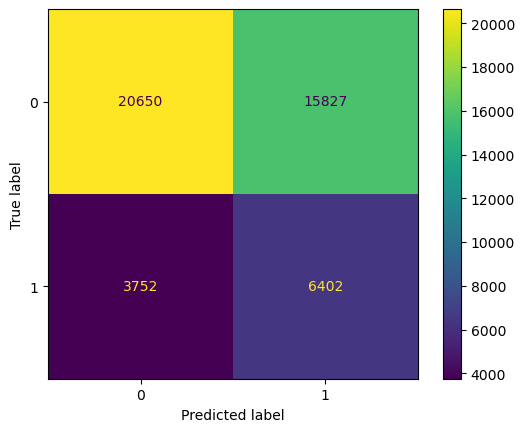

In [22]:
X_train, y_train = train_xgb_model()

In [173]:
performance_path = 'C:\\Users\\H244746\\Desktop\\Deployment Exercise\\performance_metrics\\loan_default_classifier_performance.sav'
with open(performance_path, 'rb') as handle:
    b = pickle.load(handle)

In [174]:
b

{'train_accuracy': 0.7112119039968361,
 'test_accuracy': 0.5997297934850206,
 'train_recall': 0.7402921620485948,
 'test_recall': 0.6359070317116408}

In [34]:
pipeline_path = 'C:\\Users\\H244746\\Desktop\\Deployment Exercise\\models\\loan_default_pipeline_classifier.sav'
with open(pipeline_path, 'rb') as handle:
    b = pickle.load(handle)

In [9]:
data_path = 'C:/Users/H244746/Desktop/Deployment Exercise/archive_original/train.csv'
data = pd.read_csv(data_path)


# assign target
y = data['LOAN_DEFAULT']
X = data.drop(columns = ['UNIQUEID', 'LOAN_DEFAULT'])


# select input for model
X = X[['PERFORM_CNS_SCORE','NO_OF_INQUIRIES','PRI_OVERDUE_ACCTS','STATE_ID','LTV','EMPLOYMENT_TYPE',
       'VOTERID_FLAG','DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS','PRI_SANCTIONED_AMOUNT','MANUFACTURER_ID',
       'DATE_OF_BIRTH', 'CREDIT_HISTORY_LENGTH', 'AVERAGE_ACCT_AGE']]


In [18]:
input_sample = X.iloc[0].to_dict()

In [35]:
dd = pd.DataFrame(input_sample, index = [0])
b.predict(dd)

array([1])

In [37]:
input_sample

{'PERFORM_CNS_SCORE': 0,
 'NO_OF_INQUIRIES': 0,
 'PRI_OVERDUE_ACCTS': 0,
 'STATE_ID': 6,
 'LTV': 89.55,
 'EMPLOYMENT_TYPE': 'Salaried',
 'VOTERID_FLAG': 0,
 'DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS': 0,
 'PRI_SANCTIONED_AMOUNT': 0,
 'MANUFACTURER_ID': 45,
 'DATE_OF_BIRTH': '01-01-1984',
 'CREDIT_HISTORY_LENGTH': '0yrs 0mon',
 'AVERAGE_ACCT_AGE': '0yrs 0mon'}

In [43]:
import os
os.getcwd()

'C:\\Users\\H244746\\Desktop\\Deployment Exercise\\code\\notebooks'

In [44]:
X.to_excel('train.xlsx')

In [41]:
data.sample(int(len(data)*.5))

,UNIQUEID,DISBURSED_AMOUNT,ASSET_COST,LTV,BRANCH_ID,SUPPLIER_ID,MANUFACTURER_ID,CURRENT_PINCODE_ID,DATE_OF_BIRTH,EMPLOYMENT_TYPE,...,SEC_SANCTIONED_AMOUNT,SEC_DISBURSED_AMOUNT,PRIMARY_INSTAL_AMT,SEC_INSTAL_AMT,NEW_ACCTS_IN_LAST_SIX_MONTHS,DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS,AVERAGE_ACCT_AGE,CREDIT_HISTORY_LENGTH,NO_OF_INQUIRIES,LOAN_DEFAULT
220700,625683,60547,70562,87.87,18,14115,86,2708,18-08-1985,Self employed,...,0,0,6504,0,1,0,1yrs 4mon,2yrs 11mon,1,1
24827,613056,43710,81810,55.01,10,22515,45,5660,03-02-1995,Self employed,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
189789,634725,57013,74968,78.70,11,23949,45,5969,01-01-1992,Self employed,...,0,0,0,0,1,1,1yrs 5mon,2yrs 8mon,0,1
79508,442450,47849,74320,65.93,9,22887,120,5484,01-01-1987,Self employed,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,1
131853,505349,46649,67479,71.58,34,15271,86,1000,01-06-1969,Self employed,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180985,497282,59947,73614,84.22,251,22994,45,6882,04-03-1976,Self employed,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,1
141943,589937,44394,65550,68.65,105,15792,45,1214,02-06-1996,Salaried,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
192957,597438,51178,73100,71.27,36,23978,86,6692,01-01-1980,Self employed,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,1
221563,627654,51103,68011,76.90,62,18144,86,380,09-04-1986,Self employed,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,1
